In [34]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np 

tf.random.set_seed(42)
np.random.seed(42)

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (12, 12)
mpl.rcParams["axes.grid"] = False

In [26]:
def imshow(img, title=None):
    if len(img.shape) > 3: 
        img = tf.squeeze(img, axis=0)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

def load_img(path):
    max_dim = 512

    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def download_img(link, save_to):
    path = keras.utils.get_file(save_to, link)

    return path

def prepare_img(link, save_to): 
    return load_img(download_img(link, save_to))

In [32]:
content_img = (
    "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg",
    "dog.jpg"
)
style_img = (
    "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg",
    "art.jpg"
)

content_img = prepare_img(*content_img)
style_img = prepare_img(*style_img)


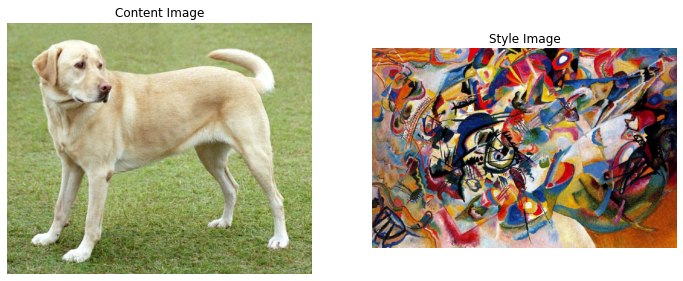

In [33]:
plt.subplot(121)
imshow(content_img, "Content Image")
plt.subplot(122)
imshow(style_img, "Style Image")
plt.show()

In [36]:
from tensorflow.keras.applications import vgg19

x = vgg19.preprocess_input(content_img * 255)
x = tf.image.resize(x, (224, 224))
model = vgg19.VGG19(include_top=True, weights="imagenet")

574726144/574710816 [==============================] - 115s 0us/step


In [37]:
predict_proba = model(x)
predict_top_5 = vgg19.decode_predictions(predict_proba.numpy())

In [42]:
for id, name, proba in predict_top_5[0]:
    print(f"{name} - {(proba*100):.2f}%")

Labrador_retriever - 49.32%
golden_retriever - 23.67%
kuvasz - 3.64%
Chesapeake_Bay_retriever - 2.42%
Greater_Swiss_Mountain_dog - 1.86%


In [47]:
keras.backend.clear_session()
model = vgg19.VGG19(include_top=False, weights="imagenet")
model.trainable = False

In [48]:
for layer in model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [49]:
def layer_outputs(names):
    outputs = [model.get_layer(name).output for name in names]
    return keras.Model([model.input], outputs)

In [52]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [50]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [51]:
style_exec = layer_outputs(style_layers)

In [69]:
# put it all together in one peace
class StyleContentModel(keras.Model):
    def __init__(self, model, style_layers, content_layers, preprocess=None):
        super(StyleContentModel, self).__init__()
        
        self.model = model
        self.model.trainable = False

        self.style_layers = style_layers
        self.content_layers = content_layers
        self.preprocess = preprocess

        self.style_model = self.get_style_model(self.model, self.style_layers + self.content_layers)
        self.style_model.trainable = False

        self.n_style_layers = len(style_layers)

    def call(self, inputs):
        "Expect float32 in [0, 1]"
        inputs = inputs*255.0

        if self.preprocess:
            inputs = self.preprocess(inputs)
        outputs = self.style_model(inputs)

        style_outputs, content_outputs = (
            outputs[:self.n_style_layers],
            outputs[self.n_style_layers:]
        )
        
        style_outputs = [StyleContentModel.gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {
            content_name: value for content_name, value in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            style_name: value for style_name, value in zip(self.style_layers, style_outputs)
        }

        return {
            "content": content_dict,
            "style": style_dict
        }

    def get_style_model(self, model, names): 
        outputs = [
            self.model.get_layer(name).output for name in names
        ]
        return keras.Model([model.input], outputs)

    @staticmethod
    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)
        

In [70]:
keras.backend.clear_session()

In [71]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

model = keras.applications.VGG19(include_top=False, weights="imagenet")
preprocessor = keras.applications.vgg19.preprocess_input

extractor = StyleContentModel(model, style_layers, content_layers, preprocessor)

In [72]:
results = extractor(tf.constant(content_img))

# print('Styles:')
# for name, output in sorted(results['style'].items()):
#       print("  ", name)
#       print("    shape: ", output.numpy().shape)
#       print("    min: ", output.numpy().min())
#       print("    max: ", output.numpy().max())
#       print("    mean: ", output.numpy().mean())
#       print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#       print("  ", name)
#       print("    shape: ", output.numpy().shape)
#       print("    min: ", output.numpy().min())
#       print("    max: ", output.numpy().max())
#       print("    mean: ", output.numpy().mean())

In [73]:
style_targets = extractor(style_img)["style"]
content_targets = extractor(content_img)["content"]

image = tf.Variable(content_img)

In [74]:
def clip_0_1(img):
    return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=0.1)
style_weight = 1e-2
content_weight = 1e4

In [85]:
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]

    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])    
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])

    return content_loss + style_loss

@tf.function()
def train_step(img):
    with tf.GradientTape() as tape: 
        outputs = extractor(img)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(clip_0_1(img))

2022-04-19 17:02:06.195532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


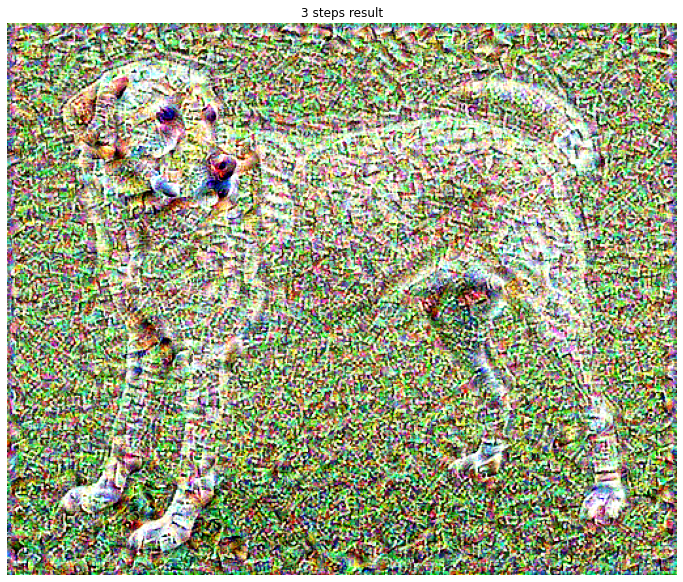

In [86]:
train_step(image)
train_step(image)
train_step(image)
imshow(image, "3 steps result")

In [90]:
import time 
start = time.time()

epochs = 10
steps_per_epoch = 100
all_steps = epochs * steps_per_epoch

with tf.device("cpu"):
    step = 0
    for n in range(epochs): 
        for m in range(steps_per_epoch):
            step += 1
            print(f"Step: {step}/{all_steps}", end="\r", flush=True)
            train_step(image)

    print(f"Took {(time.time() - start):.2f} seconds")

2022-04-19 17:11:06.903846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 